# references
- text classification with word embeddings https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
- preparing reuters https://miguelmalvarez.com/2015/03/20/classifying-reuters-21578-collection-with-python-representing-the-data/
- classifying reuters with SVM https://miguelmalvarez.com/2016/11/07/classifying-reuters-21578-collection-with-python/
- MUSE for multilingual word embeddings https://github.com/facebookresearch/MUSE
- working with pretrained word vectors https://blog.manash.me/how-to-use-pre-trained-word-vectors-from-facebooks-fasttext-a71e6d55f27
- term frequency-inverse document frequency (word weighting heuristic) https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [1]:
import keras
import numpy as np

/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Get data from nltk

In [2]:
import nltk
from nltk.corpus import reuters
#nltk.download()

### get word embeddings

In [3]:
import os
import urllib
if not os.path.exists('wiki.multi.en.vec'):
    urllib.urlretrieve ("https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec", "wiki.multi.en.vec")

In [4]:
from gensim.models import KeyedVectors
embedding = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

### get inputs


In [13]:
from helper_functions import tf_idf, feature_values, tokenize
from keras.preprocessing.sequence import pad_sequences

In [7]:
# split data and train tf_IDF
train_docs = []
test_docs = []
train_doc_ids = []
test_doc_ids = []
for doc in reuters.fileids():
    if doc.startswith("train"):
        train_doc_ids.append(doc)
        train_docs.append(reuters.raw(doc))
    else:
        test_doc_ids.append(doc)
        test_docs.append(reuters.raw(doc))
representer = tf_idf(train_docs)

In [8]:
# set max length to the 99th percentile length of all documents
MAX_SEQ_LEN = int(np.percentile([len(i) for i in train_docs+test_docs], 90))

In [11]:
# convert train docs to input
# tokenize
tokenized_inputs = [tokenize(doc, vocab=embedding.wv.vocab) for doc in train_docs]
# convert to indices and pad
def convert_to_index(doc, embedding):
    return [embedding.index2word.index(w) for w in doc]
seqs = [convert_to_index(doc, embedding) for doc in tokenized_inputs]
inputs_pad = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)

/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'pad_sequences' is not defined

### get outputs

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
categories = reuters.categories()
train_categories = [reuters.categories(doc) for doc in train_doc_ids]
test_categories = [reuters.categories(doc) for doc in test_doc_ids]
# transform into multilabel binarized representation
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([reuters.categories(doc_id)
                                  for doc_id in train_doc_ids])
test_labels = mlb.transform([reuters.categories(doc_id)
                             for doc_id in test_doc_ids])

In [18]:
from sklearn.utils import class_weight
category_list = np.hstack([np.where(doc>0)[0] for doc in train_labels])
weighted_list = class_weight.compute_class_weight('balanced', np.unique(category_list), category_list)
class_weights = {i: weighted_list[i] for i in range(len(mlb.classes_))}

### SVM classifier

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
# count representation
count_transformer = CountVectorizer(tokenizer=tokenize, min_df=3,
                        max_df=0.90, max_features=30000)
count_train_docs = count_transformer.fit_transform(train_docs)
count_test_docs = count_transformer.transform(test_docs)

In [ ]:
# get tfidf representation
tfidf_train_docs=representer.transform(train_docs)
tfidf_test_docs=representer.transform(test_docs)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# inputs
x_train = tfidf_train_docs
x_test = tfidf_test_docs

# Classifier
classifier = OneVsRestClassifier(LinearSVC(random_state=42))
classifier.fit(vectorized_train_docs, train_labels)
 
predictions = classifier.predict(vectorized_test_docs)

In [63]:
from sklearn.metrics import f1_score, precision_score,recall_score
 
precision = precision_score(test_labels, predictions,
                            average='micro')
recall = recall_score(test_labels, predictions,
                      average='micro')
f1 = f1_score(test_labels, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))
 
precision = precision_score(test_labels, predictions,
                            average='macro')
recall = recall_score(test_labels, predictions,
                      average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}"
        .format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.9422, Recall: 0.8098, F1-measure: 0.8710
Macro-average quality numbers
Precision: 0.5975, Recall: 0.3746, F1-measure: 0.4380


/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/media/Data/Ian/miniconda/envs/tf2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### set up keras classifier

In [20]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Flatten, MaxPooling1D
import keras.backend as K

In [21]:
import tensorflow as tf
def custom_objective(y_true, y_pred):
    '''Just another crossentropy'''
    # Transform to logits
    epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    y_pred = tf.log(y_pred / (1 - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weighted_list)
    return tf.reduce_mean(loss, axis=-1)


In [23]:
from numpy.random import seed
seed(1)
embedding_layer = embedding.get_keras_embedding()
sequence_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(mlb.classes_), activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss=custom_objective,
              optimizer='adam',
              metrics=['acc'])

# happy learning!
history = model.fit(inputs_pad, train_labels,
                    validation_split=0.1, batch_size=128, epochs=20)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 6992 samples, validate on 777 samples
Epoch 1/20
6992/6992 [==============================] - 6s 824us/step - loss: 0.1894 - acc: 0.0461 - val_loss: 0.0706 - val_acc: 0.0000e+00
Epoch 2/20
6992/6992 [==============================] - 4s 597us/step - loss: 0.0768 - acc: 4.2906e-04 - val_loss: 0.0701 - val_acc: 0.0000e+00
Epoch 3/20
6992/6992 [==============================] - 4s 597us/step - loss: 0.0763 - acc: 0.0275 - val_loss: 0.0734 - val_acc: 0.0000e+00
Epoch 4/20
6992/6992 [==============================] - 4s 598us/step - loss: 0.0762 - acc: 0.0330 - val_loss: 0.0703 - val_acc: 0.0000e+00
Epoch 5/20
6992/6992 [==============================] - 4s 598us/step - loss: 0.0759 - acc: 7.1510e-04 - val_loss: 0.0703 - val_acc: 0.0013
Epoch 6/20
6992/6992 [==============================] - 4s 597us/step - loss: 0.0760 - acc: 4.2906e-04 - val_loss: 0.0700 - val_acc: 0.0000e+00
Epoch 7/20
6992/6992 [

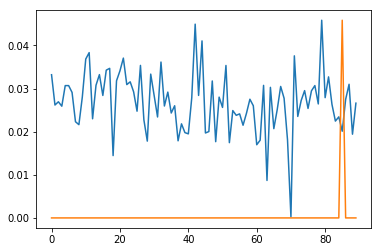

In [30]:
#pyplot inline
import matplotlib.pyplot as plt
i = 10
predict = model.predict(inputs_pad[0:50])[i]
plt.plot(predict)
plt.plot(train_labels[i]*max(predict))

In [ ]:
from sklearn.metrics import classification_report
num_examples = 50
predicted = model.predict(inputs_pad[:num_examples])>.5
y = train_labels[:num_examples]

report = classification_report(y, predicted)
print(report)